# PyTorch Workflow

1. Data - Preparation and Loading
2. Model - Building
3. Model - Fitting
4. Model - Predictions and Evaluation
5. Model - Saving and Loading
6. Summarization

In [1]:
import torch
from torch import nn # Contains PyTorch's building blocks for Neural Networks
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.4.0+cu121'

## 1. Data - Preparation and Loading

Types of data:

* Excel spreadsheet
* Images
* Videos
* Audio
* DNA
* Text

Main ML steps:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.


**Parameter:** It's what a model learns.

### Create data using Linear Regression formula

#### Create **known** parameters

These are the values that we are going to try to obtain:

In [3]:
weight = 0.7
bias = 0.3

In [4]:
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias # Linear Regression

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

## Splitting data into training and test set

In [5]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(8, 6))
  plt.scatter(train_data, train_labels, c="blue", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="green", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="red", s=4, label="Predicitons")

  plt.legend(prop={"size": 14})

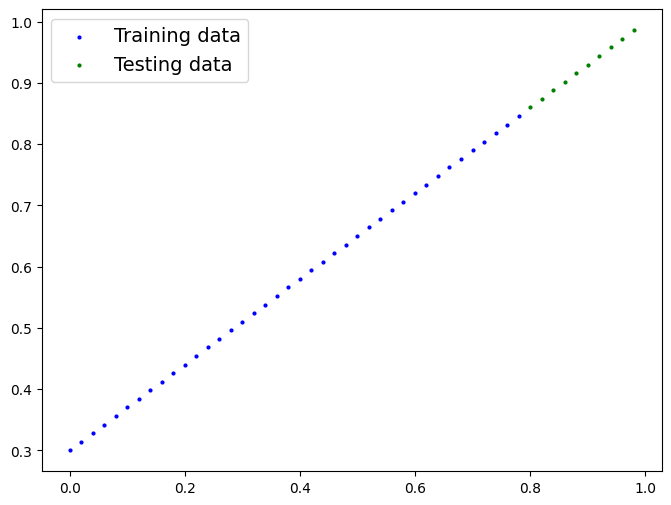

In [7]:
plot_predictions()

## 2. Build a Model

Linear Regression model example:

In [8]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias # Linear Regression formula

### PyTorch model building essentials

* torch.nn - Building blocks for computational graphs (neural networks)
* torch.nn.Parameter - What parameters should our model try and learn. PyTorch layer takes care for us
* torch.nn.Module - Base class for all network modules (override forward method)
* toch.optim - Optimizations that help with gradient descent

### Checking the contents of our PyTorch model

We can use `.parameters()` to check out our model parameters.

In [9]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
list(model_0.state_dict())

['weights', 'bias']

## Making prediction using `torch.inference_mode()`

This turns off the gradient tracking. Essentially PyTorch disables tools that are only used during training consenquently boosts performance.
We will see how well it predicts `y_test` based on `X_test`.

In [11]:
with torch.inference_mode(): # Context manager
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [12]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

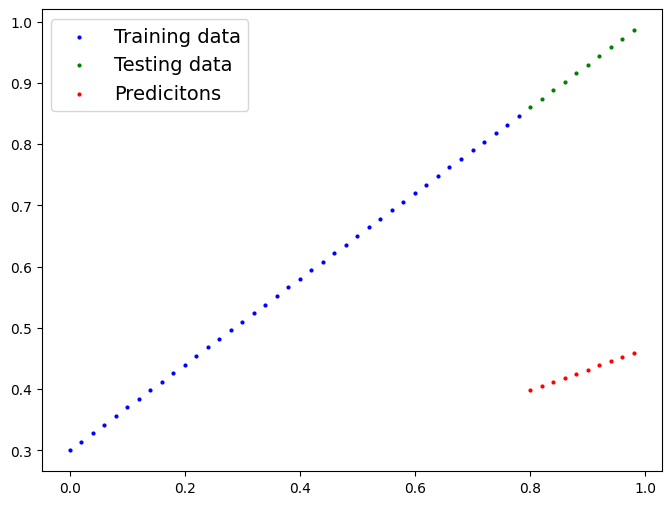

In [13]:
plot_predictions(predictions=y_preds)

## 3. Train Model

When dealing with models the aim is to move from some *unknown* parameters (these may be random) to *known* parameters.

A loss function (or cost function) is a way to measure how bad the model is.

**Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.

**Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight and bias) to improve the loss function.

**OBS:** `torch.autograd` calculates the gradients automatically in order to find the parameters with the smallest loss values. This is done by the optimizer.

And specifically dor PyTorch, we need:
* A training loop
* A testing loop

 ### Setup a loss function

In [14]:
loss_fn = nn.L1Loss()

### Setup an optimizer

In [15]:
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # Most important hyperparameter, the step taken in the random value (change in the parameter, when giding the minimum value in the loss graph)

## PyTorch training loop

For the training loop, we'll build the following steps:

| Number | Step name                               | What does it do?                                                                                                                             | Code example                  |
|--------|-----------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------|
| 1      | Forward pass                            | The model goes through all of the training data once, performing its `forward()` function calculations.                                        | `model(x_train)`              |
| 2      | Calculate the loss                      | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.                                    | `loss = loss_fn(y_pred, y_train)` |
| 3      | Zero gradients                          | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.         | `optimizer.zero_grad()`        |
| 4      | Perform backpropagation on the loss     | Computes the gradient of the loss with respect to every model parameter to be updated (each parameter with `requires_grad=True`). This is known as backpropagation, hence "backwards". | `loss.backward()`              |
| 5      | Update the optimizer (gradient descent) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them.                                   | `optimizer.step()`             |


In [25]:
epochs = 100000 # Loop through the data (hyperparameter)

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode (enables gradient)
  model_0.train()

  # 1. Forward pass (performs the forward method)
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad. It zeros the gradients of the optimizer (they accumulate by default).
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # How the optimizer change will accumulate through the loop


  # Disable gradient tracking
  model_0.eval()

In [26]:
model_0.state_dict() # We don't know the values that we need to get closer to in real life problems

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [27]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

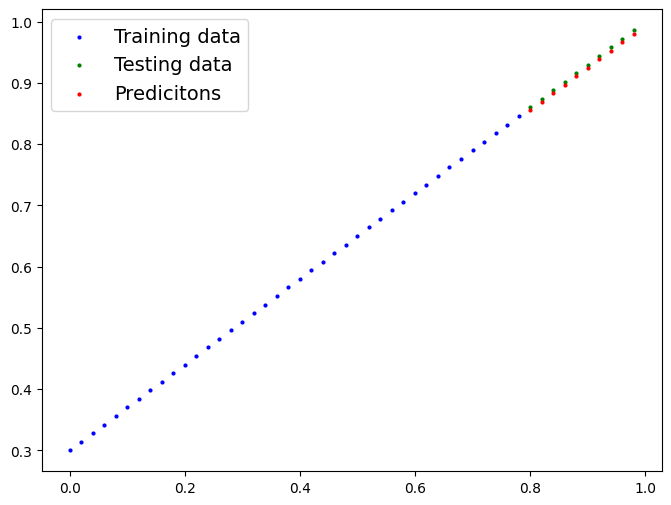

In [28]:
plot_predictions(predictions=y_preds_new)